## Business Case Description

Toronto is one of the most expensive cities in Canada, with individuals facing rising rent, tuition, and basic living expenses. Due to this, many Canadians are concerned about their financial well-being.

# Source Code

In [ ]:
pip install pandas scikit-learn xgboost shap openpyxl

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import shap

                           Mean    Median     Mode
After-Tax Income   82311.144474   72150.0  24000.0
Bank Deposits      15424.088827    6250.0      0.0
TFSA Balance       20625.877041     525.0      0.0
Net Worth         861870.488205  590000.0    275.0
Total Debt         60752.310982    4475.0      0.0
   After-Tax Income  Bank Deposits  TFSA Balance  Net Worth  Total Debt  \
0         11.657251       9.680406     11.407576  15.127351    0.000000   
1         11.706030       7.972811      9.648660  14.369913   11.884496   
2          9.861415       8.517393     10.819798  15.116383   10.596660   
3         11.901082       6.957497      9.350189  14.848357   12.247699   
4         10.946429       0.000000      0.000000  13.064524    0.000000   

      ratio  
0  0.000000  
1  0.083290  
2  0.010892  
3  0.074224  
4  0.000000  


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


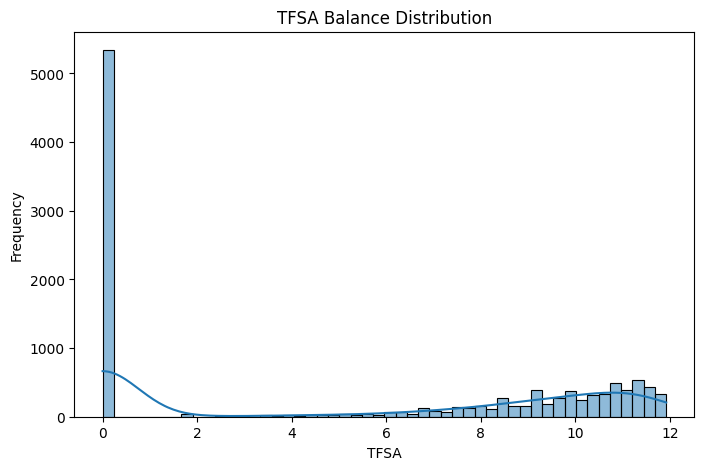

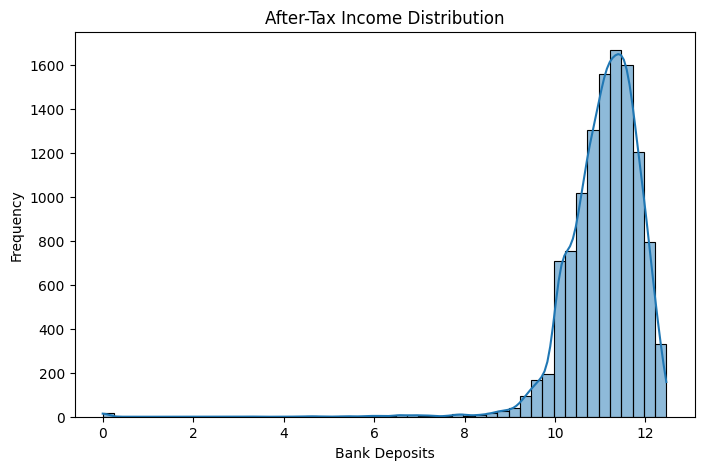

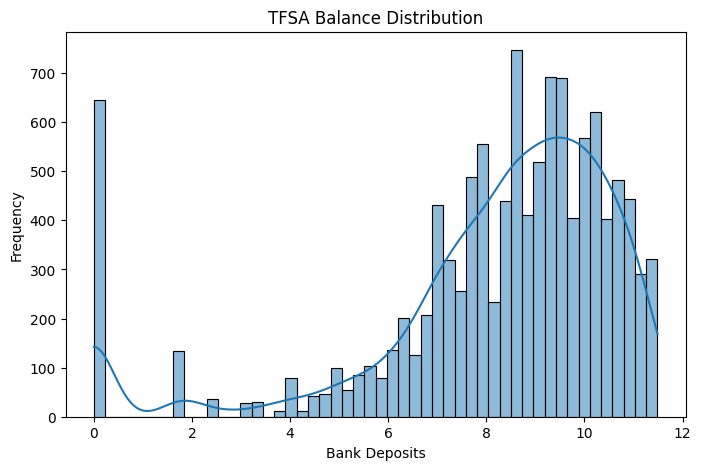

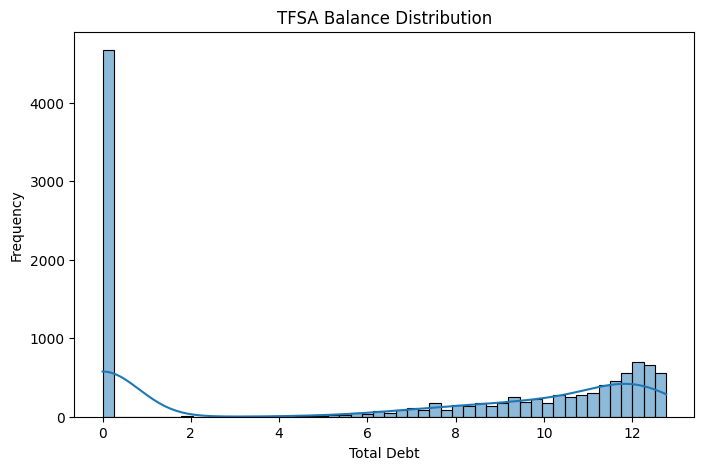

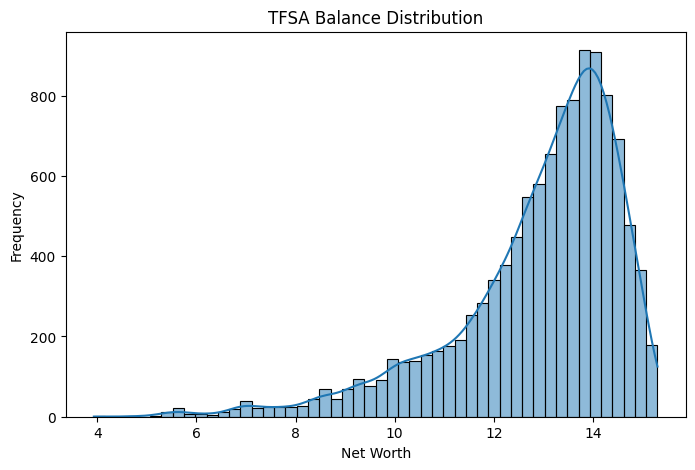

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load Excel Data
# -----------------------------

file_path = "personal_finance_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="datathon_finance", engine="openpyxl")
df = df.drop(columns=["PATTSITC", "PATTSKP", "PFTENUR", "PLFFPTME", "PNBEARG"])
df = df.drop_duplicates()
df = df.rename(columns={
    "PAGEMIEG": "Age Group",
    "PATTCRU": "Credit Card Payment",
    "PWAPRVAL": "Home Value",
    "PWASTDEP": "Bank Deposits",
    "PWATFS": "TFSA Balance",
    "PWDPRMOR": "Mortgage Debt",
    "PWDSLOAN": "Student Loan Debt",
    "PWDSTCRD": "Credit Card Debt",
    "PWDSTLOC": "Line of Credit Debt",
    "PWNETWPG": "Net Worth",
    "PPVRES": "Province",
    "PFMTYPG": "Family Type",
    "PEDUCMIE": "Education Level",
    "PEFATINC": "After-Tax Income"
})
debt_cols = ["Mortgage Debt", "Line of Credit Debt", "Credit Card Debt", "Student Loan Debt"]
df["Total Debt"] = df[debt_cols].sum(axis=1)
cal_cols = ["Net Worth", "Total Debt"]
df["ratio"] = df["Total Debt"]/(df["Net Worth"] + 0.00000001)
df = df.drop(columns=["Education Level", "Family Type", "Province",
                      "Line of Credit Debt", "Credit Card Debt",
                      "Student Loan Debt",
                      "Mortgage Debt", "Line of Credit Debt",
                      "Credit Card Debt", "Home Value", "Age Group", "Credit Card Payment"])

features = ["After-Tax Income",
    "Bank Deposits",
    "TFSA Balance",
    "Net Worth",
    "Total Debt"]


Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = ~((df[features] < lower_bound) | (df[features] > upper_bound)).any(axis=1)
df = df[mask]

summary = pd.DataFrame({
    "Mean": df[features].mean(),
    "Median": df[features].median(),
    "Mode": df[features].mode().iloc[0],
    "lower quartile": df[features].quantile(0.25),
    "upper quartile": df[features].quantile(0.75),
    "max": df[features].max(),
    "min": df[features].min()
})
print(summary)

import numpy as np
for col in features:
    df[col] = np.log1p(df[col])

pd.set_option("display.max_columns", None)
print(df.head())


plt.figure(figsize=(8,5))
sns.histplot(df["TFSA Balance"], bins=50, kde=True)
plt.xlabel("TFSA")
plt.ylabel("Frequency")
plt.title("TFSA Balance Distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(df["After-Tax Income"], bins=50, kde=True)
plt.xlabel("Bank Deposits")
plt.ylabel("Frequency")
plt.title("After-Tax Income Distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(df["Bank Deposits"], bins=50, kde=True)
plt.xlabel("Bank Deposits")
plt.ylabel("Frequency")
plt.title("TFSA Balance Distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(df["Total Debt"], bins=50, kde=True)
plt.xlabel("Total Debt")
plt.ylabel("Frequency")
plt.title("TFSA Balance Distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(df["Net Worth"], bins=50, kde=True)
plt.xlabel("Net Worth")
plt.ylabel("Frequency")
plt.title("TFSA Balance Distribution")
plt.show()

X = df[[
    "Total Debt",
    "Net Worth",
    "TFSA Balance",
    "Bank Deposits",
    "After-Tax Income"
]]

df["stress"] = ((df["Total Debt"] / df["After-Tax Income"]) > 0.35).astype(int)

y = df["stress"]

In [ ]:
# -----------------------------
# 2. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# -----------------------------
# 3. Define Base Models
# -----------------------------

# Logistic Regression (Elastic Net)
log_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logistic", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        max_iter=5000
    ))
])

# Fit on training data
log_pipeline.fit(X_train, y_train)

# Predict probabilities
probs = log_pipeline.predict_proba(X_test)[:, 1]

# Gradient Boosting (XGBoost)
xgb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("xgb", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        random_state=42
    ))
])

In [ ]:
# -----------------------------
# 4. Stacking Model
# -----------------------------

stack_model = StackingClassifier(
    estimators=[
        ("xgb", xgb_pipeline),
        ("logistic", log_pipeline)
    ],
    final_estimator=LogisticRegression()
)

stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                Pipeline(steps=[('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               feature_weights=Non...
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=300,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))])),
                               ('logistic',
                                Pipeline(steps=[('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('scaler', StandardScaler()),
                                                ('logistic',
                                                 LogisticRegression(l1_ratio=0.5,
                                                                    max_iter=5000,
                                                                    penalty='elasticnet',
                                                                    solver='saga'))]))],
                   final_estimator=LogisticRegression())

In [ ]:
# -----------------------------
# 5. Evaluate
# -----------------------------

probs_stack = stack_model.predict_proba(X_test)[:, 1]
auc_stack = roc_auc_score(y_test, probs_stack)

print("Stacked Model AUC:", auc_stack)

Stacked Model AUC: 1.0


# Logistic Regression Interpretation

In [ ]:
# Access the logistic model inside the pipeline
log_model_inside = log_pipeline.named_steps["logistic"]

coefficients = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": log_model_inside.coef_[0],
    "Odds_Ratio": np.exp(log_model_inside.coef_[0])
}).sort_values(by="Odds_Ratio", ascending=False)

print(coefficients)

           Variable  Coefficient   Odds_Ratio
0        Total Debt     9.028931  8340.937848
2      TFSA Balance    -0.028330     0.972068
4  After-Tax Income    -0.094446     0.909877
1         Net Worth    -0.106077     0.899355
3     Bank Deposits    -0.215076     0.806480


# XGBoost + SHAP (Best Variable Ranking) Interpretation

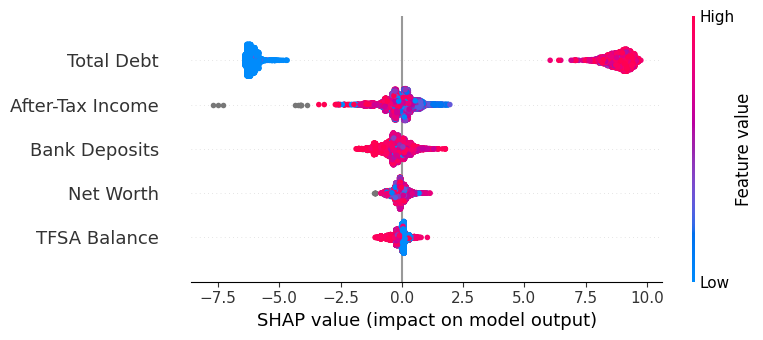

In [ ]:
xgb_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)